In [1]:
from torchtext import data
import torch
import torch.nn as nn
import torch.optim as optim
import random
import datetime
from math import floor

seed = 1
torch.manual_seed(seed)
device = torch.device('cpu')
iterator_device = None

In [2]:
blurb_field = data.Field(sequential=True, use_vocab=True, lower=True, tokenize="spacy", include_lengths=True)
state_field = data.LabelField(sequential=False, use_vocab=False, tensor_type=torch.FloatTensor,
                              preprocessing=lambda x:1 if x=='successful' else 0)
dataset = data.TabularDataset(path='df_text_eng.csv',format='csv',skip_header=True,fields=[('Unnamed: 0', None),('blurb', blurb_field),('state', state_field)])

In [3]:
train, test, validation = dataset.split(random_state=random.seed(seed), split_ratio=[70,15,15])
print("Training Set Size: ", len(train))
print("Test Set Size: ", len(test))
print("Validation Set Size: ", len(validation))

Training Set Size:  150859
Test Set Size:  32327
Validation Set Size:  32327


In [4]:
#words that appear less than 3 times (2 or less) will be considered unknown words with tag "<unk>", 
#they will have the same word embedding
#vocabulary of the training set will only be used to emulate real world situtaions when the test set is unknown
blurb_field.build_vocab(train,min_freq=3)
print("Vocabulary size used: ",len(blurb_field.vocab))

Vocabulary size used:  28760


In [5]:
batch_size = 64

train_iter = data.BucketIterator(dataset=train, batch_size=batch_size, sort_key=lambda x:len(x.blurb),device=iterator_device,
                                repeat=False, train=True, sort_within_batch=True)
test_iter = data.BucketIterator(dataset=test, batch_size=batch_size, sort_key=lambda x:len(x.blurb),device=iterator_device,
                                train=False, sort_within_batch=True)
validation_iter = data.BucketIterator(dataset=validation, batch_size=batch_size, sort_key=lambda x:len(x.blurb),device=iterator_device,
                                      train=False, sort_within_batch=True)

In [16]:
class LSTMNet(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, padding_idx=None):
        super(LSTMNet, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=padding_idx)    # word embedding
        self.lstm = nn.LSTM(embed_size, hidden_size)  #LSTM layer, default activation function is tanh
        self.out = nn.Linear(hidden_size, output_size)   # output layer (Fully Connected)

    def forward(self, x, x_lengths):
        #x -> [sentence length(max, smaller sentences are padded), minibatch size]
        embeds = self.embedding(x)
        
        #embeds -> [sentence length, minibatch size, embedding size]
        embeds = nn.utils.rnn.pack_padded_sequence(embeds,x_lengths)
        all_hiddens, (last_hidden, last_cell) = self.lstm(embeds)      # activation function for hidden layer
        #the first dimension of the hidden layer is 1 (we use one hidden layer uniderectional LSTMs), squeeze removes it to be 
        #able to enter the fully connected layer with dimensions [batch size, hidden size]
        score = self.out(last_hidden.squeeze(0))           
        return score

In [17]:
def calc_accuracy(predictions, y):
    predictions = torch.round(torch.sigmoid(predictions))
    correct = (sum(predictions == y)).float()
    accuracy = correct/len(predictions)
    return accuracy

In [18]:
padding_idx = blurb_field.vocab.stoi['<pad>']
embed_size = 100
hidden_size = 100

In [19]:
lstmmodel = LSTMNet(len(blurb_field.vocab),embed_size,hidden_size,1, padding_idx=padding_idx)
optimizer = optim.SGD(lstmmodel.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()
lstmmodel = lstmmodel.to(device)
loss_fn = loss_fn.to(device)

In [20]:
def train(model, iterator, optimizer, loss_fn):
    epoch_loss = 0
    epoch_accuracy = 0
    
    model.train()
    
    for minibatch in iterator:
        optimizer.zero_grad()
        predictions = model(minibatch.blurb[0],minibatch.blurb[1]).squeeze(1)
        loss = loss_fn(predictions, minibatch.state)
        accuracy = calc_accuracy(predictions, minibatch.state)    
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_accuracy += accuracy.item()
        
    return epoch_loss / len(iterator), epoch_accuracy / len(iterator)

In [21]:
def evaluate(model, iterator, loss_fn):
    epoch_loss = 0
    epoch_accuracy = 0
    
    model.eval()
    
    with torch.no_grad():
        for minibatch in iterator:
            predictions = model(minibatch.blurb[0],minibatch.blurb[1]).squeeze(1)
            loss = loss_fn(predictions, minibatch.state)
            accuracy = calc_accuracy(predictions, minibatch.state)    

            epoch_loss += loss.item()
            epoch_accuracy += accuracy.item()
        
    return epoch_loss / len(iterator), epoch_accuracy / len(iterator)

In [22]:
no_epochs = 100
#import ipdb; ipdb.set_trace() # debugging starts here
train_accuracies = []
validation_accuracies = []
init_time = datetime.datetime.now()
for epoch in range(no_epochs):
    train_loss, train_accuracy = train(lstmmodel, train_iter, optimizer, loss_fn)
    validation_loss, validation_accuracy = evaluate(lstmmodel, validation_iter, loss_fn)
    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)
    current_time = datetime.datetime.now()
    total_time = (current_time-init_time).total_seconds()
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}%, ' +  
          f'Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy*100:.2f}%')
    print(f'Total Time Passed: {floor(total_time/3600)} hours, {floor(total_time/60)%60} minutes, {total_time%60:.2f} seconds')

E:\Programs\Installed_Programs\Anaconda3\lib\site-packages\torchtext\data\field.py:321: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train), lengths
E:\Programs\Installed_Programs\Anaconda3\lib\site-packages\torchtext\data\field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)


Epoch: 01, Train Loss: 0.6936, Train Accuracy: 50.08%, Validation Loss: 0.6931, Validation Accuracy: 51.09%
Total Time Passed: 0 hours, 1 minutes, 59.76 seconds
Epoch: 02, Train Loss: 0.6930, Train Accuracy: 51.01%, Validation Loss: 0.6925, Validation Accuracy: 52.02%
Total Time Passed: 0 hours, 4 minutes, 3.59 seconds
Epoch: 03, Train Loss: 0.6925, Train Accuracy: 51.63%, Validation Loss: 0.6920, Validation Accuracy: 52.51%
Total Time Passed: 0 hours, 6 minutes, 4.63 seconds
Epoch: 04, Train Loss: 0.6922, Train Accuracy: 51.96%, Validation Loss: 0.6917, Validation Accuracy: 52.59%
Total Time Passed: 0 hours, 8 minutes, 15.21 seconds
Epoch: 05, Train Loss: 0.6919, Train Accuracy: 52.28%, Validation Loss: 0.6913, Validation Accuracy: 52.81%
Total Time Passed: 0 hours, 11 minutes, 7.98 seconds
Epoch: 06, Train Loss: 0.6916, Train Accuracy: 52.54%, Validation Loss: 0.6911, Validation Accuracy: 52.95%
Total Time Passed: 0 hours, 13 minutes, 19.48 seconds
Epoch: 07, Train Loss: 0.6913, Trai

Total Time Passed: 1 hours, 43 minutes, 32.72 seconds
Epoch: 52, Train Loss: 0.6871, Train Accuracy: 54.33%, Validation Loss: 0.6864, Validation Accuracy: 54.66%
Total Time Passed: 1 hours, 45 minutes, 28.49 seconds
Epoch: 53, Train Loss: 0.6870, Train Accuracy: 54.35%, Validation Loss: 0.6863, Validation Accuracy: 54.65%
Total Time Passed: 1 hours, 47 minutes, 27.09 seconds
Epoch: 54, Train Loss: 0.6870, Train Accuracy: 54.38%, Validation Loss: 0.6863, Validation Accuracy: 54.70%
Total Time Passed: 1 hours, 49 minutes, 24.81 seconds
Epoch: 55, Train Loss: 0.6869, Train Accuracy: 54.42%, Validation Loss: 0.6862, Validation Accuracy: 54.73%
Total Time Passed: 1 hours, 51 minutes, 23.74 seconds
Epoch: 56, Train Loss: 0.6868, Train Accuracy: 54.39%, Validation Loss: 0.6862, Validation Accuracy: 54.75%
Total Time Passed: 1 hours, 53 minutes, 22.56 seconds
Epoch: 57, Train Loss: 0.6868, Train Accuracy: 54.41%, Validation Loss: 0.6861, Validation Accuracy: 54.76%
Total Time Passed: 1 hours, 

In [23]:
test_loss, test_accuracy = evaluate(lstmmodel, test_iter, loss_fn)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%')

E:\Programs\Installed_Programs\Anaconda3\lib\site-packages\torchtext\data\field.py:321: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train), lengths
E:\Programs\Installed_Programs\Anaconda3\lib\site-packages\torchtext\data\field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)


Test Loss: 0.6858, Test Accuracy: 54.66%


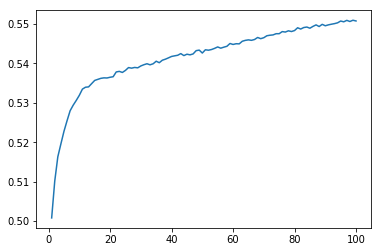

In [26]:
import matplotlib.pyplot as plt

plt.plot(range(1,no_epochs+1),train_accuracies)
plt.show()